In [1]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
NUM_CROPS = 1
IN_ROWS = 40
IN_COLS = 40
OUT_ROWS = 20
OUT_COLS = 20
Y1 = 10
X1 = 10
Y2 = Y1 + OUT_ROWS
X2 = X1 + OUT_COLS
CROP_COORDS_HARD = np.array([Y1, X1, Y2, X2])

TESTBENCH_TYPE = "VALUE_EQUALS_INDEX"
assert(TESTBENCH_TYPE in ["VALUE_EQUALS_INDEX"]) # ["REAL_DATA", "VALUE_EQUALS_INDEX", "RANDOM"])
if TESTBENCH_TYPE=="VALUE_EQUALS_INDEX":
    FP_FRAC = 0 # We just want integer values corresponding to the index of each pixel
    FP_INT = int(np.log2(IN_ROWS*IN_COLS)) + 1 # We need enough bits to represent the largest index
    FP_TOTAL = FP_FRAC + FP_INT + 1 # We'll keep it signed for simplicity
    STRING_INSERT = "_INDEX"
    VMAX = IN_ROWS*IN_COLS
elif TESTBENCH_TYPE=="REAL_DATA":
    FP_FRAC = 13
    FP_INT = 2
    FP_TOTAL = FP_FRAC + FP_INT + 1
    STRING_INSERT = ""
    VMAX = 1
elif TESTBENCH_TYPE=="RANDOM":
    FP_FRAC = 13
    FP_INT = 2
    FP_TOTAL = FP_FRAC + FP_INT + 1
    STRING_INSERT = "_RANDOM"
    VMAX = 1
else: raise NotImplementedError

print(f"FP_TOTAL: {FP_TOTAL}")
print(f"FP_INT: {FP_INT}")
print(f"FP_FRAC: {FP_FRAC}")

os.makedirs("tb_data", exist_ok=True)
os.makedirs("tb_data/float32", exist_ok=True)
os.makedirs(f"tb_data/ap_fixed_{FP_TOTAL}_{FP_INT}", exist_ok=True)

FP_TOTAL: 12
FP_INT: 11
FP_FRAC: 0


In [3]:
def float_to_fixed_point(value: float, total_bits: int, fractional_bits: int) -> str:
    """
    Convert a float to a fixed-point binary representation.
    
    :param value: Float value to convert.
    :param total_bits: Total number of bits for the representation.
    :param fractional_bits: Number of fractional bits.
    :return: Fixed-point binary string.
    """
    scale = 2 ** fractional_bits
    fixed_point_value = int(round(value * scale))
    
    # Handle two's complement representation for negative numbers
    if fixed_point_value < 0:
        fixed_point_value = (1 << total_bits) + fixed_point_value
    
    return f"{fixed_point_value:0{total_bits}b}"


def fixed_point_to_float(binary: str, fractional_bits: int) -> float:
    """
    Convert a fixed-point binary representation to a float.
    
    :param binary: Fixed-point binary string.
    :param fractional_bits: Number of fractional bits.
    :return: Float value.
    """
    total_bits = len(binary)
    int_value = int(binary, 2)
    
    # Handle two's complement for negative numbers
    if int_value >= (1 << (total_bits - 1)):
        int_value -= (1 << total_bits)
    
    return int_value / (2 ** fractional_bits)

# Save float data

In [4]:
tb_input = np.array([i for i in range(IN_ROWS*IN_COLS)]).reshape((IN_ROWS, IN_COLS)).astype(np.float32)
tb_output = tb_input[Y1:Y2, X1:X2].astype(np.float32)
print(f"tb_input.shape: {tb_input.shape}")
print(f"tb_output.shape: {tb_output.shape}")

np.save(os.path.join("tb_data/float32", "crop_coords.npy"), CROP_COORDS_HARD)
np.save(os.path.join("tb_data/float32", "tb_input.npy"), tb_input)
np.save(os.path.join("tb_data/float32", "tb_output.npy"), tb_output)

tb_input.shape: (40, 40)
tb_output.shape: (20, 20)


# Save ap_fixed binary data

In [5]:
fpath_tb_input_ap_fixed = os.path.join(f"tb_data/ap_fixed_{FP_TOTAL}_{FP_INT}", f"tb_input{STRING_INSERT}_{IN_ROWS}x{IN_COLS}_to_{OUT_ROWS}x{OUT_COLS}x{NUM_CROPS}.bin")
with open(fpath_tb_input_ap_fixed, "w") as f:
    for row in tb_input:
        for val in row:
            val_fixed = float_to_fixed_point(val, FP_TOTAL, FP_FRAC)
            f.write(f"{val_fixed}\n")


fpath_tb_output_ap_fixed = os.path.join(f"tb_data/ap_fixed_{FP_TOTAL}_{FP_INT}", f"tb_benchmark_output{STRING_INSERT}_{IN_ROWS}x{IN_COLS}_to_{OUT_ROWS}x{OUT_COLS}x{NUM_CROPS}.bin")
with open(fpath_tb_output_ap_fixed, "w") as f:
    for row in tb_output:
        for val in row:
            val_fixed = float_to_fixed_point(val, FP_TOTAL, FP_FRAC)
            f.write(f"{val_fixed}\n")

# Inspect reconstruction accuracy 

Of input

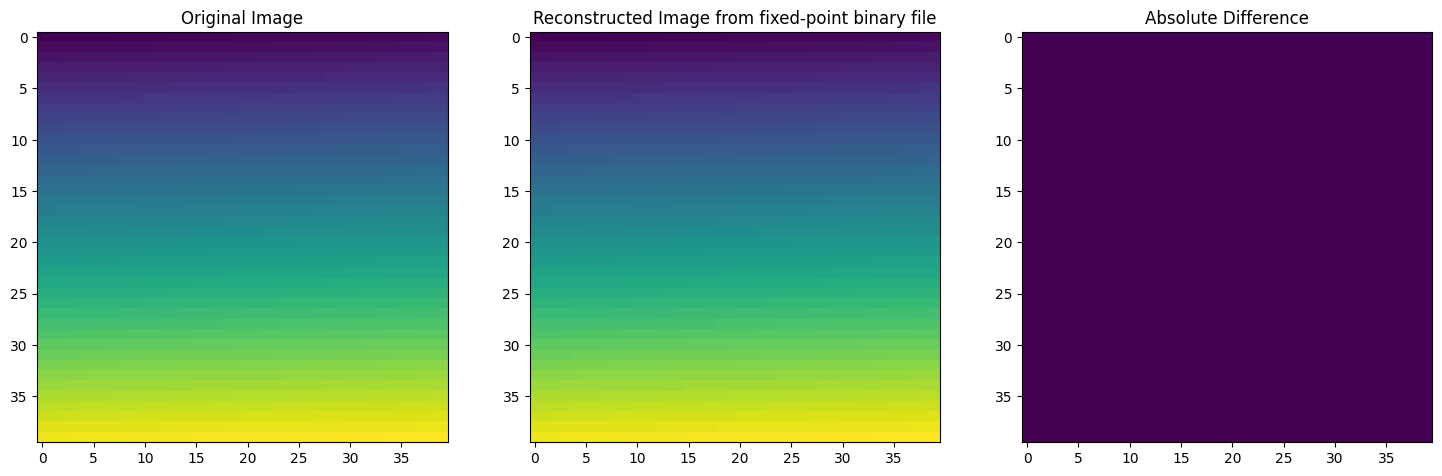

0.0


In [6]:
tb_input_ap_fixed_reconstructed = np.zeros((IN_ROWS, IN_COLS))
with open(fpath_tb_input_ap_fixed, 'r') as f:
    for i, line in enumerate(f):
        row = i//IN_COLS
        col = i%IN_COLS
        line = line.replace("\n", "")
        x = fixed_point_to_float(line, FP_FRAC)
        tb_input_ap_fixed_reconstructed[row, col] = x

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,6))

ax1.imshow(tb_input, vmin=0, vmax=VMAX)
ax1.set_title("Original Image")

ax2.imshow(tb_input_ap_fixed_reconstructed, vmin=0, vmax=VMAX)
ax2.set_title("Reconstructed Image from fixed-point binary file")

ax3.imshow(abs(tb_input.squeeze() - tb_input_ap_fixed_reconstructed), vmin=0, vmax=VMAX)
ax3.set_title("Absolute Difference")

plt.show(fig)
plt.close(fig)

print(np.max(np.abs(tb_input.squeeze() - tb_input_ap_fixed_reconstructed)))

Of ideal output

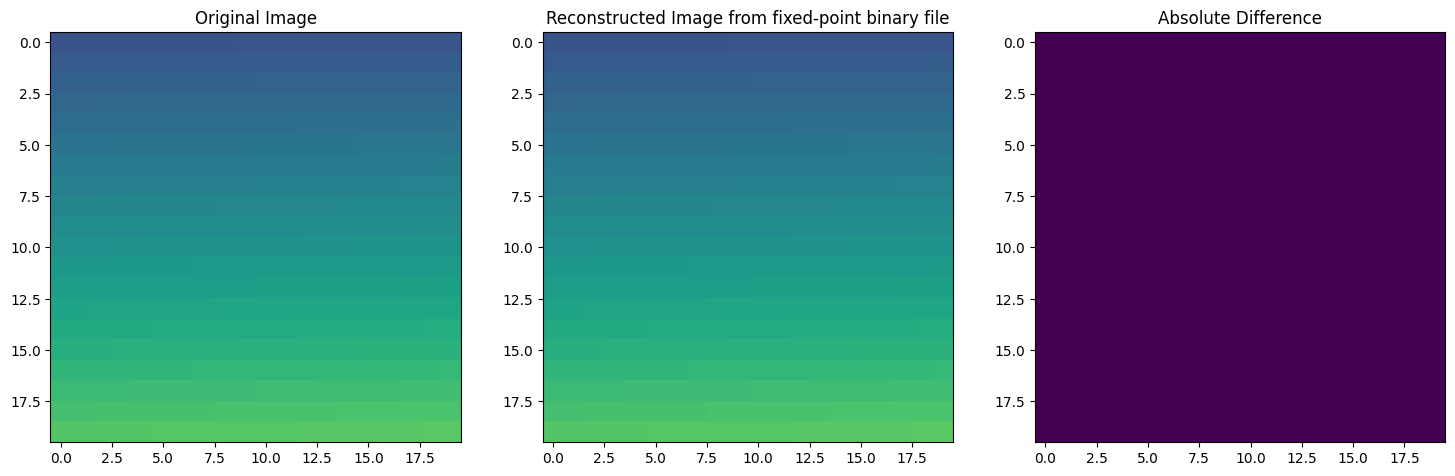

0.0


In [7]:
tb_output_ap_fixed_reconstructed = np.zeros((OUT_ROWS, OUT_COLS))
with open(fpath_tb_output_ap_fixed, 'r') as f:
    for i, line in enumerate(f):
        row = i//OUT_COLS
        col = i%OUT_COLS
        line = line.replace("\n", "")
        x = fixed_point_to_float(line, FP_FRAC)
        tb_output_ap_fixed_reconstructed[row, col] = x

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,6))

ax1.imshow(tb_output, vmin=0, vmax=VMAX)
ax1.set_title("Original Image")

ax2.imshow(tb_output_ap_fixed_reconstructed, vmin=0, vmax=VMAX)
ax2.set_title("Reconstructed Image from fixed-point binary file")

ax3.imshow(abs(tb_output.squeeze() - tb_output_ap_fixed_reconstructed), vmin=0, vmax=VMAX)
ax3.set_title("Absolute Difference")

plt.show(fig)
plt.close(fig)

print(np.max(np.abs(tb_output.squeeze() - tb_output_ap_fixed_reconstructed)))